- Tutorial from [here](https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7)
- Code [here](https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch)
- original paper :[here](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)
- Siamese nets were first introduced in the early 1990s by Bromley and LeCun to solve signature verification

additional detail the paper use
- use Regularization
- Early stop if no derease error for 20 epochs
- layerwise learning rate ηj ∈ [10−4
, 10−1
], layer-wise momentum µj ∈ [0, 1], and layer-wise L2 regularization penalty
λj ∈ [0, 0.1]
- Affine distortions (augmented data)
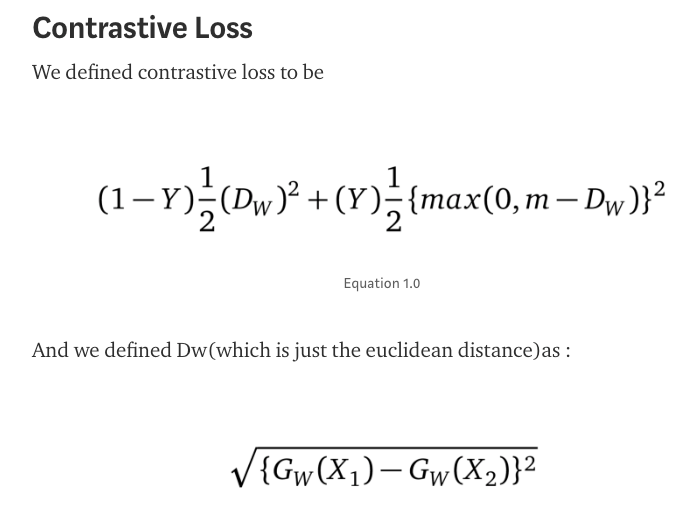

In [1]:
%reload_ext autoreload
%autoreload 2
import random
import numpy as np
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms
import torchvision
from exitai.learner import Learner

%matplotlib inline
import matplotlib.pyplot as plt

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
def random_dict(dict_obj):
    key = random.choice(list(dict_obj))
    return dict_obj[key]
def random_except(arr, except_value):
    random_value = random.choice(arr)
    if random_value == except_value:
        return random_except(arr, except_value)
    return random_value
class OneShotDataset(Dataset):
    
    def __init__(self, dataset):
        self.class_dict = {}
        self.dataset = dataset
        
        for data, label in self.dataset:
            if label not in self.class_dict:
                self.class_dict[label] = []
            self.class_dict[label].append((data, label))
        
    def __getitem__(self, index):
        image_0, class_0 = random.choice(random_dict(self.class_dict))
        is_same_class = random.randint(0, 1) # to make sure getting images from same class 50%
        if is_same_class:
            class_1 = class_0
        else:
            class_1 = random_except(list(self.class_dict), class_0)
        image_1, class_1 = random.choice(self.class_dict[class_1])
        
        return image_0, image_1, torch.tensor(is_same_class, dtype=torch.float32)
    def __len__(self):
        return len(self.dataset)

In [23]:
transform_train = transforms.Compose([
                                   transforms.RandomCrop(32, padding=4),
#                                    transforms.RandomHorizontalFlip(), # in MNIST cannot flip
                                   transforms.RandomAffine(15, scale=(.9,1.2)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (1,))
                               ])
transform_test = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (1,))
                               ])
dataset_train = OneShotDataset(datasets.MNIST(root='../../data/', train=True, download=True, transform=transform_train))
dataset_test = OneShotDataset(datasets.MNIST(root='../../data/', train=False, download=False, transform=transform_test))
data_loader_train = DataLoader(dataset_train, shuffle=True, num_workers=8)
data_loader_test = DataLoader(dataset_test, shuffle=True, num_workers=8)


In [14]:
# import torchvision.models as models
# model = models.resnet18(pretrained=True)

In [49]:
class LeNetOneShot(nn.Module):
    def __init__(self):
        super(LeNetOneShot, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 20, 5, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(20, 50, 5, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.fc = nn.Sequential(
            nn.Linear(5*5*50, 500),
            nn.Linear(500, 100)
        )
        
    def forward_once(self, x):
        output = self.cnn(x)
        output = output.view(-1, 50*5*5)
        output = self.fc(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
    
    def name(self):
        return "LeNetOneShot"
model = LeNetOneShot().to(device)


In [47]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output, label):
        output1, output2 = output
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive
criterion = ContrastiveLoss()

In [42]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)
counter = []
loss_history = [] 
for epoch in range(10):
    for i, (image_1, image_2, is_same) in enumerate(data_loader_train):
        image_1 = image_1.to(device)
        image_2 = image_2.to(device)
        is_same = is_same.to(device)
        optimizer.zero_grad()
        y1, y2 = model(image_1, image_2)
        loss_contrastive = criterion(y1, y2, is_same)
        loss_contrastive.backward()
        optimizer.step()
    print(f'Epoch {epoch}, loss: {loss_contrastive.item()}')
    counter.append(epoch)
    loss_history.append(loss_contrastive.item())

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: torch.Size([1, 50, 5, 5])
output2: torch.Size([1, 1250])
output1: t

Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/epinyoanun/miniconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/epinyoanun/miniconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/epinyoanun/miniconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/epinyoanun/miniconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/epinyoanun/miniconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/epinyoanun/miniconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File

KeyboardInterrupt: 

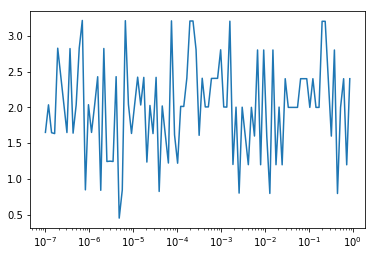

In [50]:
learner = Learner(data_loader_train, data_loader_test, model, criterion)
learner.lr_find(1e-7, 1)

In [53]:
def eval_func(loss, output, target):
    output1, output2 = output
    euclidean_distance = F.pairwise_distance(output1, output2)
    return 0
learner.fit(1, num_epochs=2, cycle=None, eval_func=eval_func)

---- epoch:0 ------


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/epinyoanun/miniconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/epinyoanun/miniconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/epinyoanun/miniconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/epinyoanun/miniconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/epinyoanun/miniconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/epinyoanun/miniconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/epinyoanun/miniconda3/lib/

KeyboardInterrupt: 